# Projet numérique de Science des Données 2025

__Binôme numéro 49 -- FELIERS Lise et THOMPSON Emile__

## Introduction

Dans ce projet, il s'agira d'étudier un jeu de données concernant des femmes diabétiques enceintes. Le diabète constitue un facteur de risque pour le bon déroulé de la grossesse. Pour chacune de ces femmes, nous disposons de 7 variables :
* `Age` : l'âge en années
* `Tension systolique` : la tension systolique en mmHg
* `Tension diastolique` : la tension diastolique en mmHg
* `Glycémie` : glycémie post-prandiale en mmol/L
* `Température` : température en °C
* `FC au repos` : fréquence cardiaque au repos
* `Risque` : degré de risque obstétrique (0 : faible, 1 : moyen, 2 : élevé)


Ce projet comporte trois partie :
1. Une analyse exploratoire des données
2. La construction d'un classifieur binaire permettant de séparer les femmes dont la grossesse est à risque de celles dont elle ne l'est pas
3. La construction d'un classifieur multi-classe permettant de séparer les grossesses en trois classes : hautement à risque, moyennement à risque, faiblement à risque.

## Instructions 
* Former un binôme et l'inscrire dans Moodle.
* Renseigner le numéro de binôme et vos noms tout en haut de ce notebook à l'emplacement indiqué.
* Déposer ce notebook complété **au plus tard le 10 juillet 2025, 23h59** sur Moodle.

La présence aux séances dédiés au mini-projet (20/06 et 7/07) est **notée**. 

Les questions **1 à 14** peuvent être traitées dès la première séance. 
La question **15** peut être traitée après la PC4.
Les questions **16 à 30** peuvent être traitées à partir de la PC5.

Pour des raisons pédagogiques (voir la note à ce sujet), **l'usage d'assistants de code ou d'agents conversationnels tels que ChatGPT, Copilot, Claude, LeChat est prohibé. Leur utilisation sera sanctionnée.**

### Question 1 (1pt)

Les données ont été récoltées dans une région défavorisée du monde, où les populations sont très pauvres et peuvent difficilement consulter. Quel peut être l'intérêt de déléguer à un algorithme la prédiction du risque obstétrique ? Quelles peuvent être les dérives (sociales, éthiques, économiques, psychologiques) d'une telle pratique ?

### Réponse

Déléguer à un algorithme de prédiction permet d'avoir une idée du risque obstétrique dans une région du monde qui n'a pas forcément beaucoup d'étude sur la question.   
  
Mais cela implique de donner des informations personnelles à un algorithme.

## Librairies usuelles

In [1]:
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.rc('font', **{'size': 12}) # règle la taille de police globalement pour les plots (en pt)

np.random.seed(19) 

## Chargement des données

Nous allons pour l'instant travailler avec le jeu de données d'entraînement `data/donnees_entrainement.csv` :

In [2]:
df_train = pd.read_csv('data/donnees_entrainement.csv')

Commençons par en extraire deux arrays, `X_train` et `y_train`, contenant d'une part les variables décrivant les observations et d'autre part leurs étiquettes :

In [3]:
X_train = np.array(df_train.drop('Risque', axis=1))
y_train = np.array(df_train['Risque'], dtype='int')


# 1. Exploration de données

## Distributions des variables

### Question 2 (1 pt)
Pour chaque variable, affichez un histogramme de sa distribution dans chacune des trois classes.

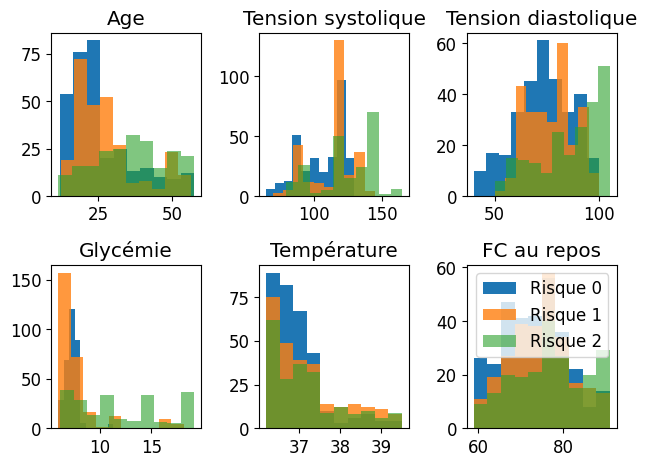

In [4]:
fig = plt.figure()

for (i, variable) in enumerate(df_train.columns[:6]):

    ax = fig.add_subplot(2, 3, (i+1))

    h = ax.hist(df_train[df_train['Risque']==0][variable], bins=10,  
                color='tab:blue', edgecolor='none', alpha=1, label='Risque 0')
    h = ax.hist(df_train[df_train['Risque']==1][variable], bins=10,  
                color='tab:orange', edgecolor='none', alpha=0.8, label='Risque 1')
    h = ax.hist(df_train[df_train['Risque']==2][variable], bins=10,  
                color='tab:green', edgecolor='none', alpha=0.6, label='Risque 2')

    ax.set_title(variable)
plt.legend()

fig.tight_layout(pad=1.0)

### Question 3 (1 pt)
Les valeurs prises par ces variables sont-elles surprenantes ? Cohérentes avec le degré de risque ?

### Réponse

L'age des femmes enceintes est assez surprenant, on a une grande partie des femmes étudiées qui ont moins de 20ans. Ceci peut être dû à la région d'étude qui est défavorisée. On remarque que plus l'age, la tension systolique/diastolique et la glycémie sont élevés, plus les niveaux de risques plus élevés.

### Question 4 (1 pt)
Pensez-vous qu'il va être facile/difficile de prédire le risque de grossesse à risque en utilisant ces 6 variables ?

### Réponse

Cela va être plutôt difficile : il y atoujours des cas de risque 2 qui sont au même niveau que les risque 0 et 1. Mais il peut y avoir des certitudes : haute température, haute glycémie impliquent un risque 1 ou 2.

## Réduction de dimension

Indépendamment de votre réponse à la question précédente, nous allons procéder à deux tentatives de réduction de dimension.

### Question 5 (1 pt)
Utilisez la décomposition en composantes principales de `X_train` pour visualiser les données en deux dimensions.

(800, 2)


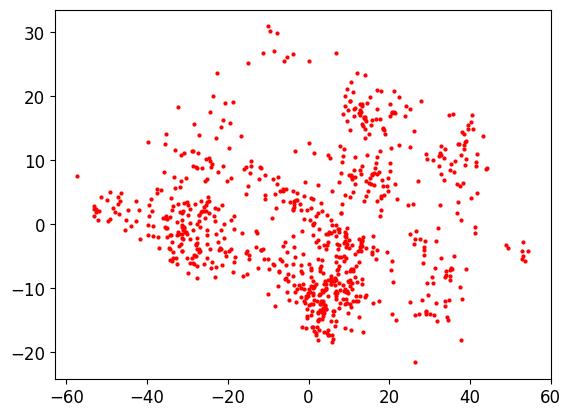

In [5]:
from sklearn import decomposition

# Instanciation d'un objet PCA pour 2 composantes principales
pca = decomposition.PCA(n_components=2)


pca.fit(X_train)

X_projected = pca.transform(X_train)
print(X_projected.shape)

plt.plot(X_projected[:, 0], X_projected[:, 1], "or", ms = 2)
plt.show()

### Question 6 (1 pt) 
Pensez-vous utile d'utiliser cette ACP pour réduire la dimension des données pour construire un prédicteur de risque de grossesse difficile ?

### Réponse

Au vu de la répartition des points, ce ne serait pas pertinent : il n'y a aucune droite qui se démarque.

### Question 7 (0,5 pt)
Affichez la matrice de corrélation entre les variables (étiquette exclue)

Text(0.5, 1.0, 'Corrélation entre les variables - Risque 2')

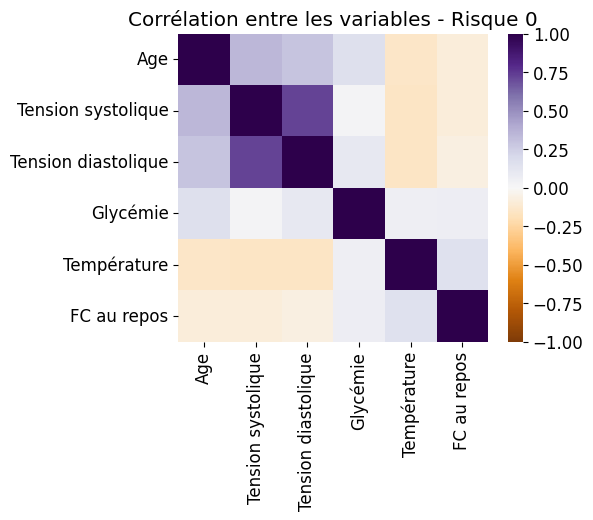

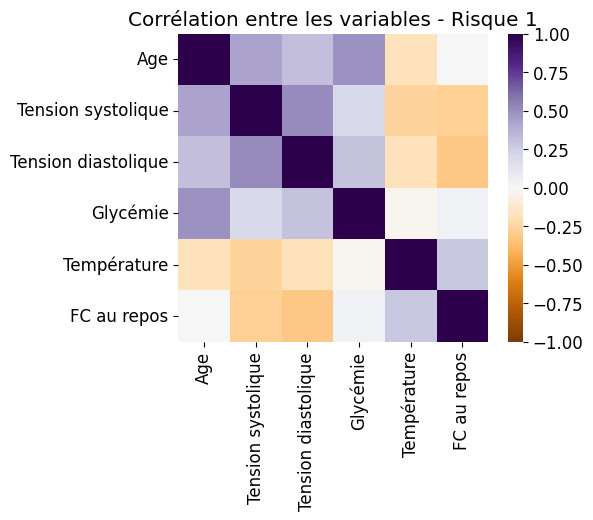

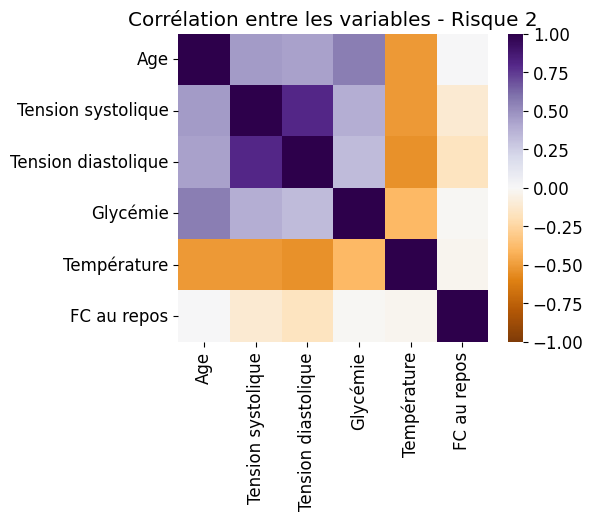

In [6]:
import seaborn as sns
# Calcul de la matrice de corrélation deux à deux
corr_matrix = df_train[df_train['Risque']==0].drop('Risque', axis=1).corr()

# Initialisation figure
fig = plt.figure(figsize=(5, 4))

# Affichage heatmap
sns.heatmap(corr_matrix, 
            vmin=-1, # borne inf des valeurs à afficher
            vmax=1, # borne sup des valeurs à afficher
            center= 0, # valeur médiane des valeurs à afficher,
            cmap='PuOr', # colormap divergente de violet (PUrple) vers orange (ORange)
           )
# Titre
plt.title("Corrélation entre les variables - Risque 0")

corr_matrix = df_train[df_train['Risque']==1].drop('Risque', axis=1).corr()

# Initialisation figure
plt.figure(figsize=(5, 4))

# Affichage heatmap
sns.heatmap(corr_matrix, 
            vmin=-1, # borne inf des valeurs à afficher
            vmax=1, # borne sup des valeurs à afficher
            center= 0, # valeur médiane des valeurs à afficher,
            cmap='PuOr', # colormap divergente de violet (PUrple) vers orange (ORange)
           )
# Titre
plt.title("Corrélation entre les variables - Risque 1")

corr_matrix = df_train[df_train['Risque']==2].drop('Risque', axis=1).corr()

# Initialisation figure
plt.figure(figsize=(5, 4))

# Affichage heatmap
sns.heatmap(corr_matrix, 
            vmin=-1, # borne inf des valeurs à afficher
            vmax=1, # borne sup des valeurs à afficher
            center= 0, # valeur médiane des valeurs à afficher,
            cmap='PuOr', # colormap divergente de violet (PUrple) vers orange (ORange)
           )
# Titre
plt.title("Corrélation entre les variables - Risque 2")

### Question 8 (0,5 pt)

Comment utiliser cette matrice de corrélation pour réduire la dimension des données ?

### Réponse

Cette matrice de corrélation permet de voir quelles observations sont corrélées : par exemple la tension systolique et la tension diastolique. Ces observations vont donc apporter la même information, n'en garder qu'une serait pertinent.

# 2. Classification «à risque» vs «sans risque»

Nous allons maintenant transformer les étiquettes en étiquettes binaire, en regroupant les risques obstétriques moyens et élevés. Les étiquettes `1` et `2` seront regroupées en une seule étiquette `1`.

In [7]:
# Copier le dataframe initial dans un nouveau dataframe 
df_train_risk_vs_norisk = df_train.copy()

# Regrouper les étiquettes 1 et 2
df_train_risk_vs_norisk['Risque'] = np.where(df_train['Risque']==2, 1, df_train['Risque'])

# Extraction de l'array d'étiquettes
y_train_risk_vs_norisk = np.array(df_train_risk_vs_norisk['Risque'], dtype='int')

## Choix du critère d'évaluation
Pour cette section, on pourra se référer à la section 8.7.1 du poly.

### Question 9 (0,25 pt)
Quelle serait l'_accuracy_ (proportion d'observations correctement étiquetées) d'un modèle qui prédit que toutes les observations appartiennent à la classe majoritaire (c'est-à-dire la classe ayant le plus grand nombre d'observations dans les données) ? 

In [8]:
nb_risque1 = 0
for i in y_train_risk_vs_norisk:
    nb_risque1 += i
accuracy = nb_risque1/len(y_train_risk_vs_norisk)
print (accuracy)
# Résultat supérieur à 0.5, la classe 1 est majoritaire, résultat = 0.605

0.605


### Question 10 (0,25 pt) 
La __précision équilibrée__ (_balanced accuracy_) d'un classifieur binaire est donnée par :

$$BA = \frac12 \left( \frac{\text{TP}}{\text{TP}+\text{FN}} +  \frac{\text{TN}}{\text{TN}+\text{FP}} \right)$$

Expliquez pourquoi ce critère d'évaluation est plus pertinent que l'accuracy pour sélectionner un classifieur optimal.

### Réponse

BA mesure non seulement le rappel mais aussi la spécificité. On a alors un indicateur sur la proportion d’exemples positifs correctement identifiés, ainsi que la proportion d'exemples négatifs correctement identifiés, peu importe la classe. L'accuracy ne caractérise que les vrais positifs de la classe majoritaire.

Dans la suite du projet, nous utiliserons ce critère, implémenté dans la méthode [metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) de scikit-learn.

## Plus proche voisin
L'algorithme du plus proche voisin associe à une observation $\vec{x}$ l’étiquette du point du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 11 (0,5 pt)
En quoi consiste la phase d'entraînement d'un tel classifieur ?

### Réponse
L'algorithme du plus proche voisin attribue le label du voisin le plus proche. Donc sur le jeu d'entrainement, le voisin le plus proche est le point lui-même.

### Question 12 (0,5 pt)
Quelle précision équilibrée attendez-vous _sur le jeu d'entraînement_ d'un algorithme du plus proche voisin ? Pourquoi ?

### Réponse
La précision vaut 1 car chaque point se choisit lui-même

### Question 13 (0,5 pt)
Vérifiez votre réponse sur les données, en utilisant la classe [neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

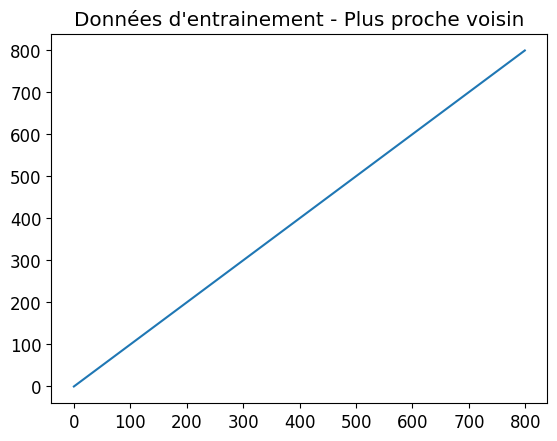

In [9]:
from sklearn import neighbors

KNClassifier = neighbors.KNeighborsClassifier(n_neighbors=1)

KNClassifier.fit(df_train_risk_vs_norisk, y_train_risk_vs_norisk)
_, knn = KNClassifier.kneighbors(df_train_risk_vs_norisk)

plt.plot(knn) # On trace les plus proches voisins en fonction des données d'entrainement, on remarque que c'est les mêmes valeurs.
plt.title("Données d'entrainement - Plus proche voisin")
plt.show()


### Quesion 14 (0,5 pt)
Pour cet algorithme, vaut-il mieux utiliser les données d'origine ou les données centrées-réduites ? Justifiez votre réponse.

### Réponse
Il faut utiliser les données centrées réduites pour que les variables aient toutes le meme poids dans le calcul de la distance euclidienne. Les ordres de grandeur sont différents donc l'impact des variables n'est pas équilibré tel quel.

## K plus proches voisins
L'algorithme des $K$ plus proche voisins associe à une observation $\vec{x}$ l’étiquette qui est majoritaires parmi celle des $K$ points du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 15 (1,5 pt)
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ (voir amphi 7 et PC5) pour déterminer une valeur optimale de $K$. 

* Justifiez votre choix de grille de valeurs.
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

### Remarque
Pour cette question, nous avons procédé à la main, sans utiliser Gridsearch, pour comprendre la démarche.

K=1 => précision équilibrée moyenne: 0.736
K=2 => précision équilibrée moyenne: 0.735
K=3 => précision équilibrée moyenne: 0.717
K=4 => précision équilibrée moyenne: 0.732
K=5 => précision équilibrée moyenne: 0.703
K=6 => précision équilibrée moyenne: 0.709
K=7 => précision équilibrée moyenne: 0.710
K=8 => précision équilibrée moyenne: 0.722
K=9 => précision équilibrée moyenne: 0.718
K=10 => précision équilibrée moyenne: 0.725
K=11 => précision équilibrée moyenne: 0.722
K=12 => précision équilibrée moyenne: 0.736
K=13 => précision équilibrée moyenne: 0.724
K=14 => précision équilibrée moyenne: 0.734
K=15 => précision équilibrée moyenne: 0.724
K=16 => précision équilibrée moyenne: 0.730
K=17 => précision équilibrée moyenne: 0.716
K=18 => précision équilibrée moyenne: 0.713
K=19 => précision équilibrée moyenne: 0.703
K=20 => précision équilibrée moyenne: 0.702
K=21 => précision équilibrée moyenne: 0.694
K=22 => précision équilibrée moyenne: 0.692
K=23 => précision équilibrée moyenne: 0.6

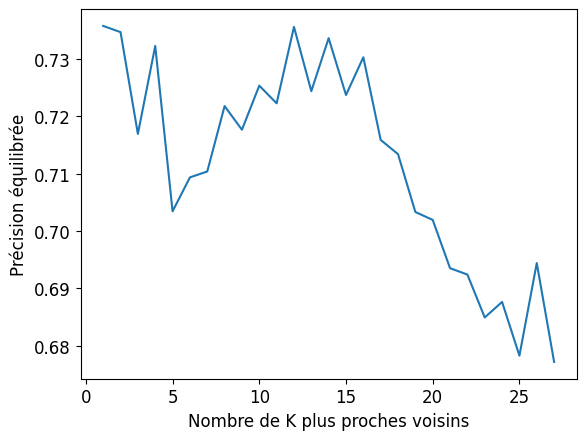

In [10]:
from sklearn import model_selection
from sklearn.metrics import balanced_accuracy_score

kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

X = df_train_risk_vs_norisk.iloc[:, :-1]  # toutes les colonnes sauf la dernière (Risque)
y = y_train_risk_vs_norisk

précisions_k = []

max_k = int(np.floor(np.sqrt(len(X)))) # On fixe notre recherche de k entre 1 et sqrt(n), bon compromis entre sur et sous apprentissage

for k in range(1, max_k): # on effectue la prédiction pour chaque valeur de k
    
    précisions_folds = []
    KNClassifier = neighbors.KNeighborsClassifier(n_neighbors=k)
        
        # 1. Création des sous-ensembles
    for train_index, test_index in kf.split(X): # on Construit les folds, et on fait la prédiction sur chaque fold, on fait ensuite la moyenne sur tous les folds pour chaque k 
            
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        KNClassifier.fit(X_train, y_train)
        y_pred = KNClassifier.predict(X_test)

        score = balanced_accuracy_score(y_test, y_pred) # on regarde la précision équilibrée vue plus haut
        précisions_folds.append(score)
        p_moy_folds = np.mean(précisions_folds)
            
    précisions_k.append((k,p_moy_folds))


K = []
P = []
for k, p in précisions_k:
    print(f"K={k} => précision équilibrée moyenne: {p:.3f}")
    K.append(k)
    P.append(p)

plt.plot(K,P)
plt.xlabel("Nombre de K plus proches voisins")
plt.ylabel("Précision équilibrée")
plt.show()


### Réponse
Au delà de k=1, la meilleure précision équilibrée est trouvée pour k=12 avec p=0.736. En dessous de k=12 on a du sous apprentissage, et au delà on a du sur apprentissage.

## Régression logistique
Le pendant pour la classification binaire de la régression linéaire (amphi 7 et PC 5) est la __régression logistique__ (PC 6). Dans scikit-learn, elle est implémentée par la classe [linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

### Question 16 (1 pt) 
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ pour déterminer une valeur optimale du coefficient de régularisation d'une régression logistique. 

* Justifiez votre choix de type de régularisation et de grille de valeurs. 
* Illustrez par un graphique approprié votre exploration de cette grille. 
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

### Remarque
Ici, nous allons procéder avec Gridsearch comme nous l'avons vu dans la PC5

In [ ]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X) # On commence par centrer réduire nos variables


# Définir la grille de valeurs de l'hyperparamètre lambda
C = np.logspace(-3, 3, 200)

# Définir le modèle à tester
log_reg = linear_model.LogisticRegression(penalty='l2')

# Instantier la recherche sur grille
grid_log_reg = model_selection.GridSearchCV(log_reg, {'C': C}, 
                                          cv=kf, 
                                          scoring='balanced_accuracy'
                                         )

# Utiliser la recherche sur grille
grid_log_reg.fit(X_scaled, y)




,estimator,LogisticRegression()
,param_grid,{'C': array([1.0000...00000000e+03])}
,scoring,'balanced_accuracy'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


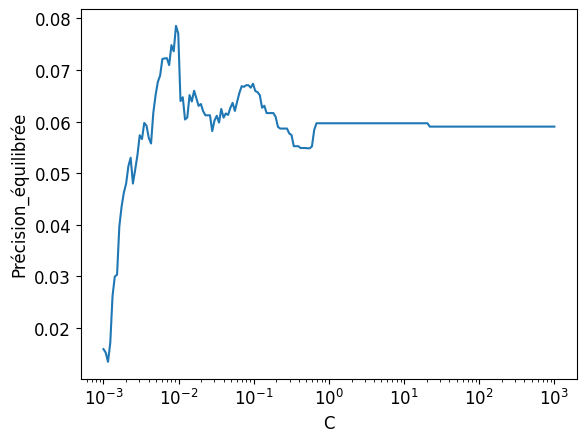

In [12]:
précision_équilibrée = grid_log_reg.cv_results_['std_test_score']
C_tracé = grid_log_reg.cv_results_['param_C']
plt.semilogx(C_tracé,précision_équilibrée)
plt.ylabel("Précision_équilibrée")
plt.xlabel("C")
plt.show()

### Réponse

Après avoir esssayé pour plusieurs plages, on constate qu'au-delà de $C =  10^{3} $, le tracé est constant, d'où notre intervalle.
On trouve un maximum de pécision pour C=0.68 avec p = 0.08.
Pour un coefficient de régularisation élevé ( C < 0.01), la précision chute vers 0.
Pour un coefficient de régularisation faible ( C > 1), la précision se stabilise à 0.06.

Ces valeurs de précisions sont très faibles

## Algorithme non-linéaire

### Question 17 (2pt)
Choisissez maintenant un algorithme permettant d'apprendre un modèle non-linéaire parmi ceux du chapitre 9 :
* arbre de décision : [tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* forêt aléatoire : [ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* machine à vecteur de support à noyau : [svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* perceptron multi-couche : [neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Utilisez encore une fois une recherche sur grille avec une validation croisée en 10 _folds_ pour sélectionner le(s) hyperparamètre(s) le(s) plus pertinent(s).

* Justifiez votre choix d'hyperparamètre(s) à optimiser.
* Justifiez votre choix de grille de valeurs pour ces ou cet hyperparèmtre(s).
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la ou les valeur(s) optimale(s) d'hyperparamètre(s) et la précision équilibrée correspondante.

In [15]:
from sklearn import svm
from sklearn import model_selection
import numpy as np

# Définir la grille de valeurs de l'hyperparamètre C
C = np.logspace(-3,1,200)

# Définir le modèle à tester
vect_sup = svm.SVC(kernel='linear')

# Instantier la recherche sur grille
grid_vect_sup = model_selection.GridSearchCV(vect_sup, {'C': C}, 
                                    cv=kf, 
                                    scoring='balanced_accuracy'
                                   )

grid_vect_sup.fit(X_scaled, y)

,estimator,SVC(kernel='linear')
,param_grid,{'C': array([1.0000...00000000e+01])}
,scoring,'balanced_accuracy'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,np.float64(1.0353218432956626)


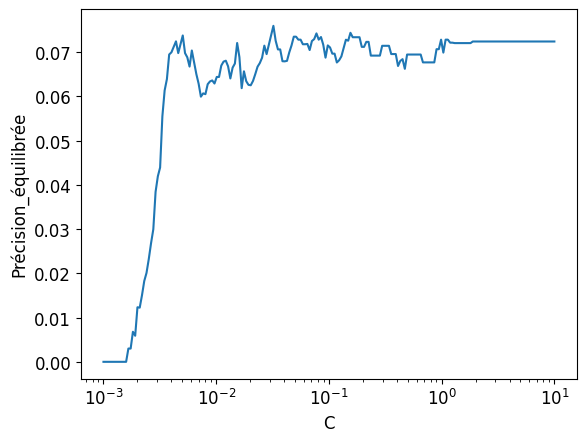

In [16]:
précision_équilibrée = grid_vect_sup.cv_results_['std_test_score']
C_tracé = grid_vect_sup.cv_results_['param_C']
plt.semilogx(C_tracé,précision_équilibrée)
plt.ylabel("Précision_équilibrée")
plt.xlabel("C")
plt.show()

Après avoir esssayé pour plusieurs plages, on constate qu'au-delà de $C =  10^{1} $, le tracé est constant, d'où notre intervalle.
On trouve un maximum de pécision pour C=1.04 avec p = 0.072.
Pour un coefficient de régularisation élevé ( C < 0.01), la précision chute vers 0.
Pour un coefficient de régularisation faible ( C > 1), la précision se stabilise à 0.07.

Ces valeurs de précisions sont très faibles

## Classification après réduction de dimension

Nous allons maintenant évaluer l'impact d'une réduction de dimension sur la qualité de l'apprentissage.

### Question 18 (0,25 pt)
Quel algorithme (k plus proches voisins ; régression logistique ; algorithme non-linéaire de la question 16) vous a permis d'obtenir la meilleure performance ? 

### Réponse

La meilleure performance est obtenue avec la méthode des K plus proches voisins, avec une précision maximale de 0.736. C'est également l'algorithme le plus rapide à exécuter.

### Quesion 19 (0,25 pt)
Utilisez le travail des questions 4 à 7 pour créer une nouvelle matrice représentant les données dans moins de dimensions qu'originellement. 

### Question 20 (0,25 pt)
Utilisez encore une fois une recherche sur grille pour optimiser les performances de cet algorithme, mais entrainé sur cette nouvelle matrice. 

In [ ]:
from sklearn import model_selection

# Définir la grille de valeurs de l'hyperparamètre K
K = np.arange(1, max_k,1)

# Définir le modèle à tester
knn = neighbors.KNeighborsClassifier(10)

# Instantier la recherche sur grille
grid = model_selection.GridSearchCV(knn, param_grid = {'n_neighbors':K},
                                    cv=kf,
                                    scoring='balanced_accuracy') #D'après Q.10

grid.fit(X_proj, y)


### Question 21 (0,25 pt)
La réduction de dimension a-t-elle été utile ? Commentez.

## Classifieur final

### Question 22 (0,25 pt)
Au vu des performances observées jusqu'à présent, quel est l'algorithme d'apprentissage, son ou ses valeurs d'hyperparamètres, la transformation des données qui permettent d'obtenir la meilleure performance ? 

Utilisez cet algorithme pour entraîner un modèle de classification final `final_binary_classifier` sur l'ensemble du jeu d'entraînement.

### Question 23 (0,25 pt)

Chargez les données du jeu de test `data/donnees_reservees.csv`. Combinez les étiquettes 1 et 2 en une seule classe. 

In [18]:
import pandas as pd

df_test = pd.read_csv('data/donnees_reservees.csv')

In [19]:
# Copier le dataframe initial dans un nouveau dataframe 
df_test_risk_vs_norisk = df_test.copy()

# Regrouper les étiquettes 1 et 2
df_test_risk_vs_norisk['Risque'] = np.where(df_test['Risque']==2, 1, df_test['Risque'])

# Extraction de l'array d'étiquettes
y_test_risk_vs_norisk = np.array(df_test_risk_vs_norisk['Risque'], dtype='int')

### Question 24 (0,25 pt)

Utilisez `final_binary_classifier` pour prédire les étiquettes des observations de ce jeu de données. (N'oubliez pas d'appliquer d'éventuelles transformation des données.) 

### Question 25 (0,5 pt)
Comparez la précision équilibrée sur le jeu de test à celle obtenue en validation croisée lors de la sélection de modèle. Commentez.

### Question 26 (0,25 pt)
Utilisez [metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) pour afficher la matrice de confusion de ces prédictions.

### Question 27 (0,5 pt)
Commentez cette matrice de précision.

Considéreriez vous possible d'utilise ce classifieur pour décider, sur la base de ces quelques mesures faciles à obtenir en autonomie, quelles femmes référer pour un suivi médical attentif de leur grossesse ?

# 3. Classification multi-classe

### Question 28 (0,5 pt)
Parmi les algorithmes d'apprentissage supervisé que vous avez utilisé dans la section 2, le(s)quel(s) se prête(nt) directement à entraîner un classifieur multiclasse ?

Algorithmes d'apprentissage supervisé :
- Algorithme des K plus proches voisins
- SVM

### Question 29 (1,5 pt)
Choisissez un des algorithmes mentionnés à la question précédente et entraînez-le sur le problème de classification multi-classe consistant à prédire le niveau (0, 1 ou 2) de risque obstétrique. Optimisez le ou les hyperparamètre(s) le(s) plus pertinent(s).

### Question 30 (1pt)
Utilisez cet algorithme pour entraîner un modèle multi-classe final sur l'ensemble des données d'entraînement. Évaluez ce modèle sur les données de test. Commentez.